(1000,)
[array([3.88207389, 6.24960852]), array([-1.86354128,  3.74763004]), array([0.02406711, 4.61266037]), array([1.72957103, 5.30211248])]


d:\Users\l\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


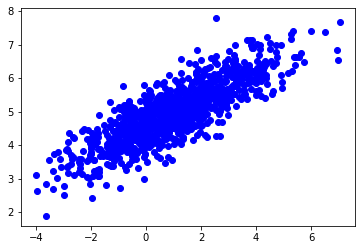

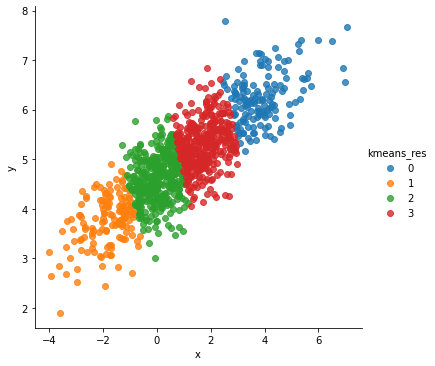

In [11]:
# -*- coding: utf-8 -*-
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from random import shuffle  # 用于打乱数据
from numpy import array
import pandas as pd
import seaborn as sns

#禁用TF2.x中的eager
tf.compat.v1.disable_eager_execution()

# 1、生成随机测试数据
sampleNo = 1000  # 数据数量
mu = 3
# 产生二维正态分布数据,加大数据之间的差异
mu = np.array([[1, 5]])

Sigma = np.array([[1, 0.5],
                  [1.5, 3]])
# 返回L的下三角阵
R = cholesky(Sigma)

# dot运算为矩阵的点积(矩阵相乘),srcdata存储的实际是模拟产生的所有点
srcdata = np.dot(np.random.randn(sampleNo, 2), R) + mu

# 画出当前的所有点
plt.plot(srcdata[:, 0], srcdata[:, 1], 'bo')


# 2、定义K-means算法

# 2.1 、定义K-means算法函数
def kmeans(vectors, k_num):
    """
    使用 TensorFlow 实现K-Means 算法
    :param vectors: 是一个 n * k 的Numpy数组，n代表k维向量的数量，也就是模拟产生的数据点的Tensor
    :param k_num: 表示需要分类的个数,是一个整数
    """
    # 将 k 转换为整数
    k_num = int(k_num)

    # 异常处理，防止后续数组下标越界,防止出现分类个数大于实际的点的个数，如分4类，然而只有2个点的情况
    assert k_num < len(vectors)

    # 找出每个向量的维度,平面点的维度为2(x,y)，空间点维度为3(x,y,z)
    dim = len(vectors[0])

    # 获取 vectors 长度大小的随机数据(本例中为1000)
    vector_indices = list(range(len(vectors)))

    # 打乱 vector_indices 中的所有数据，能够更好的泛化
    shuffle(vector_indices)

    # 计算图
    # 我们创建了一个默认的计算流的图用于整个算法中，这样就保证了当函数被多次调用
    # 时，始终使用的是默认的图
    # https://www.cnblogs.com/studylyn/p/9105818.html
    graph = tf.Graph()
    with graph.as_default():
        # 创建会话
        with tf.compat.v1.Session() as sess:
            # 构建基本的计算的元素
            # 首先我们需要保证每个中心点都会存在一个Variable矩阵
            # 从现有的点集合中 vector_indices 抽取出前 k_num 个数据作为默认的中心点,并且定义为 tf 的变量,
            # 用于后续的中心点的运算
            centroids = [tf.Variable((vectors[vector_indices[i]]))for i in range(k_num)]

            # 创建一个placeholder用于存放各个分类的中心点
            centroid_value = tf.placeholder(dtype=tf.float64, shape=[dim])

            # centroid_value = tf.placeholder("float64", [dim])

            # 给 k_num 个中心点向量进行赋值,cent_assigns 用于保存中心点的位置信息
            cent_assigns = []
            for centroid in centroids:
                cent_assigns.append(tf.assign(centroid, centroid_value))

            # assignments 用于保存 sampleNo 个点的经过计算分类后位置
            assignments = [tf.Variable(0) for i in range(len(vectors))]
            # 存储每个单独的点到 k_num 个分类的最短距离
            assignment_value = tf.placeholder(dtype=tf.int32)
            # cluster_assigns 的大小是 sampleNo = 1000,存储的是每个点到 k_num 个中心点中的最小的一个距离
            cluster_assigns = []
            # 初始化 cluster_assigns
            for assignment in assignments:
                cluster_assigns.append(tf.assign(assignment, assignment_value))

            # 下面创建用于计算平均值的操作节点
            # 输入的placeholder
            mean_input = tf.placeholder(dtype=tf.float64, shape=[None, dim])
            # 节点/OP接受输入，并且计算0维度的平均值，如输入的向量列表
            mean_op = tf.reduce_mean(mean_input, 0)

            # 用于计算欧几里得距离的节点 distance = ((x1 - x2)^2 + (y1 - y2)^2)^(1/2)
            v1 = tf.placeholder(dtype=tf.float64, shape=[dim])
            v2 = tf.placeholder(dtype=tf.float64, shape=[dim])
            # 注意：tf.mul  tf.sub   tf.neg 已经废弃, 分别可用tf.multiply  tf.subtract  tf.negative替代.
            euclid_dist = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(v1, v2), 2)))

            # 这个OP会决定应该将向量归属到哪个节点
            # 基于向量到中心点的欧几里得距离
            # Placeholder for input
            centroid_distances = tf.placeholder(dtype=tf.float64, shape=[k_num])
            # cluster_assignment 计算 k_num 个中心点的最短欧几里得距离
            cluster_assignment = tf.argmin(centroid_distances, 0)

            # 初始化所有的状态值,Variable_initializer应该定
            # 义在所有的Variables被构造之后，这样所有的Variables才会被纳入初始化
            init_op = tf.global_variables_initializer()

            # 初始化所有的变量
            sess.run(init_op)

            # 创建tensor图,并保存在当前的log目录下
            tf.summary.FileWriter("./log", sess.graph)

            # 集群遍历
            # 接下来在K-Means聚类迭代中使用最大期望算法。为了简单起见，只让它执行固
            # 定的训练的次数为20次，而不设置一个终止条件
            noofiterations = 20
            for iteration_n in range(noofiterations):

                # 期望步骤
                # 基于上次迭代后算出的中心点的位置
                # 1.首先遍历所有的向量,len(vectors)在此案例中值为 sampleNo = 1000
                # 计算每个点到 k_num 个分类中心点的最短距离,并存储在 cluster_assigns 中
                for vector_n in range(len(vectors)):
                    # 获取第 vector_n 个向量,取值范围在[0,999]
                    vect = vectors[vector_n]

                    # 当前点与 k_num 个分类的中心点欧几里得距离
                    distances = [sess.run(euclid_dist, feed_dict={
                        v1: vect, v2: sess.run(centroid)}) for centroid in centroids]

                    # 获取当前点到 k_num 个分类中心点的最短距离,目的是为了后续选择最近距离的中心点
                    assignment = sess.run(cluster_assignment, feed_dict={
                        centroid_distances: distances})

                    # 接下来为每个向量分配合适的值
                    sess.run(cluster_assigns[vector_n], feed_dict={
                        assignment_value: assignment})

                # 2.将所有点进行分类
                # 基于上述的期望步骤，计算每个新的中心点的距离从而使集群内的平方和最小
                for cluster_n in range(k_num):
                    # 收集 k_num 个分类中,对应每个分类的数据
                    assigned_vects = [vectors[i] for i in range(len(vectors))
                                      if sess.run(assignments[i]) == cluster_n]

                    # 采用平均值的计算方式重新计算每个分类集群新的中心点
                    new_location = sess.run(mean_op, feed_dict={
                        mean_input: array(assigned_vects)})

                    # 为 k_num 个分类分配新的中心点
                    sess.run(cent_assigns[cluster_n], feed_dict={
                        centroid_value: new_location})

            # 返回 k_num 个中心节点
            centroids = sess.run(centroids)
            # 返回 k_num 个分组
            assignments = sess.run(assignments)

            return centroids, assignments


# 2.2、定义聚类的个数,并使用kmeans算法去计算
k = 4
center, result = kmeans(srcdata, k)

print (np.shape(result))


# 打印 k 个中心点
print (center)

# 3、整理结果,并且使用 seaborn 画图
res = {"x": [], "y": [], "kmeans_res": []}

for i in range(len(result)):
    res["x"].append(srcdata[i][0])
    res["y"].append(srcdata[i][1])
    res["kmeans_res"].append(result[i])

pd_res = pd.DataFrame(res)
sns.lmplot("x", "y", data=pd_res, fit_reg=False, height=5, hue="kmeans_res")
plt.show()